# **Problem statement:** <br/>
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the **presence of melanoma** has the potential to reduce a lot of manual effort needed in diagnosis.

## Dataset details
The dataset consists of **2357 images** of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

# GDrive opertions
- Mount drive
- Unzip files to the location


Below code is commented as it was for working with Google Colab

In [1]:
# !pip install pydot

In [2]:
# #mount google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# sample_files_path = '/content/drive/MyDrive/Colab Notebooks/Upgrad/Sample/'
sample_file_zip = 'CNN_assignment.zip'

In [4]:
# with ZipFile(f'{sample_files_path}{sample_file_zip}', 'r') as zipObj:
#   zipObj.extractall(f'{sample_files_path}')

Unzipping the files

In [5]:
import zipfile
with zipfile.ZipFile(f'{sample_file_zip}', 'r') as zip_ref:
    zip_ref.extractall()

All the files are unzipped and kept in the same folder from which we read it.

# Import Libraries
- Import all the libraries
- Check for GPU
- Declare training and test paths

In [6]:
import numpy as np
import pandas as pd
import os
import PIL

import keras
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# train_dir_path = '/content/drive/MyDrive/Colab Notebooks/Upgrad/Sample/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
# test_dir_path = '/content/drive/MyDrive/Colab Notebooks/Upgrad/Sample/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

# Data Reading/Data Understanding
→ Defining the path for train and test images
- Load all files using the pathlib
- Count the number of sample images avaialable in Train and Test

In [9]:
train_dir_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_dir_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [10]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(train_dir_path)
data_dir_test = pathlib.Path(test_dir_path)

In [11]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset Creation
- Create train & validation dataset from the train directory with a batch size of 32.
- Also, make sure you resize your images to 180*180.

In [12]:
batch_size = 32
img_height = 180
img_width = 180

### Train Test split
- Split the data set in 80-20 split to train and validate
- Using seed → 123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
- While writting the dataset, resizing the images to the size img_height*img_width

Train DS

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Validation DS

In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.



# Dataset visualisation
→ Create a code to visualize one instance of all the nine classes present in the dataset
- List out all the classes of skin cancer and store them in a list.
- Class names can be found in the class_names attribute on these datasets.
- These correspond to the directory names in alphabetical order.

In [15]:
cancer_class_names = train_ds.class_names
print(f'Count of classes, {len(cancer_class_names)}')
print(cancer_class_names)

Count of classes, 9
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Here is the code to visualise the cancer images

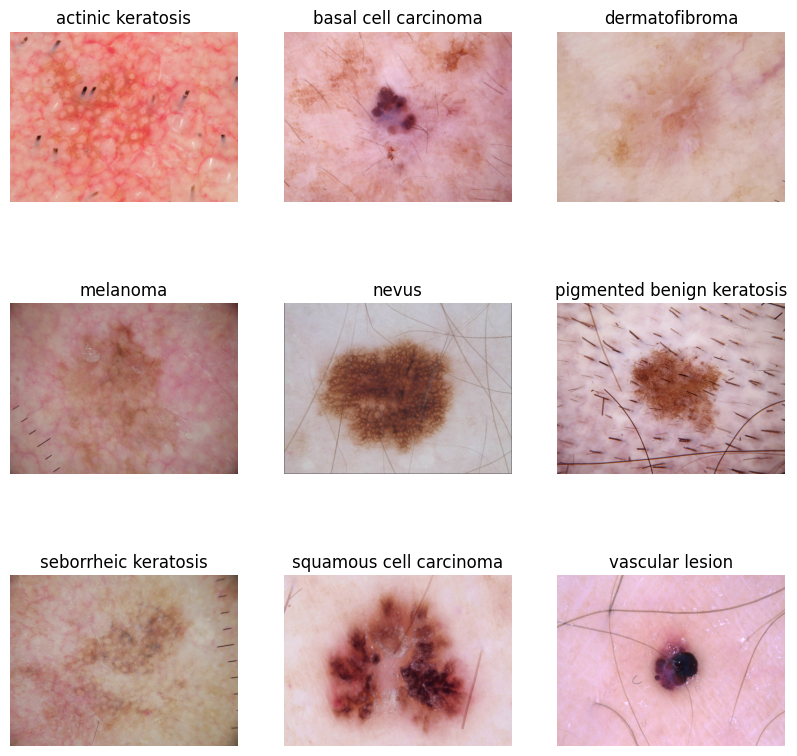

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{cancer_class_names[i]}/*.jpg'))[1]))
  plt.title(cancer_class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of shape (32, 180, 180, 3)
- `180, 180` is the `height and width` of the images
- `3` is the color channel `RGB`
- `32` is the batch size which means a 32 images of shape `180*180*3`

# Model Building & training :
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

- tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Model Architecture

#### Sequential allows you to create models layer-by-layer
Step 1
- Create a CNN model, which can accurately detect 9 classes present in the dataset


In [18]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation= 'relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16,
                 kernel_size=(7, 7),
                 padding = 'Same',
                 activation= 'relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,
                 kernel_size=(11,11),
                 padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

/Users/mohit.dubey/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 2
- Choose an appropriate optimiser and loss function for model training

In [19]:
def compileModel(model):
  opt=tf.keras.optimizers.Adam()
  model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [20]:
compileModel(model=model)

#### Model Summary

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Step 3
- Train the model for ~20 epochs

In [22]:
# # vizualizing the model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
epochs = 20
lr = 1e-5
init = 'normal'
activ = 'relu'

In [24]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=5,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=lr)

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
# checkpoint = ModelCheckpoint("model.h5",
#                              monitor="val_accuracy",
#                              save_best_only=True,
#                              mode="auto",
#                              verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)

In [25]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = [learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.1755 - loss: 2.0861 - val_accuracy: 0.2058 - val_loss: 2.0785 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.1979 - loss: 2.0085 - val_accuracy: 0.2058 - val_loss: 2.0421 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.2135 - loss: 2.0136 - val_accuracy: 0.2215 - val_loss: 1.9904 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.2064 - loss: 2.0122 - val_accuracy: 0.2058 - val_loss: 2.0223 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.2134 - loss: 2.0058 - val_accuracy: 0.2953 - val_loss: 1.9321 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.3116 - loss: 1.8798 - val_accuracy: 0.3490 - val_loss: 1.7300 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.3037 - loss: 1.

In [26]:
len(history.epoch)

20

## Visualising the results
- Graph between training and validation accuracy
- Graph between training and validation loss

In [27]:
def visualiseResult(model):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.epoch))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

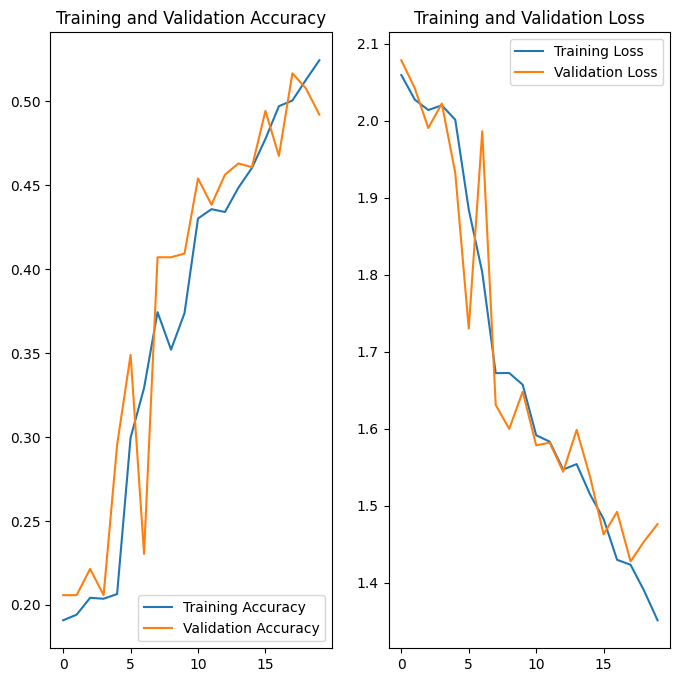

In [28]:

visualiseResult(model=model)

Step 4
Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.
- The Training accuracy and validation accuracy are almost same, but it is low which shows that the model is `underfit`.
- Too much fluctuation in training data
- Training loss is low but the value is fluctuating

Hence we can conclude that the model is not good enough

# Overfitting or Underfitting
Chose an appropriate data augmentation strategy to resolve underfitting/overfitting

- As we observed that the data is underfit, let's choose an appropriate data augumentation strategy.
- augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue

In [29]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
  ]
)

2024-04-15 14:24:59.537291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


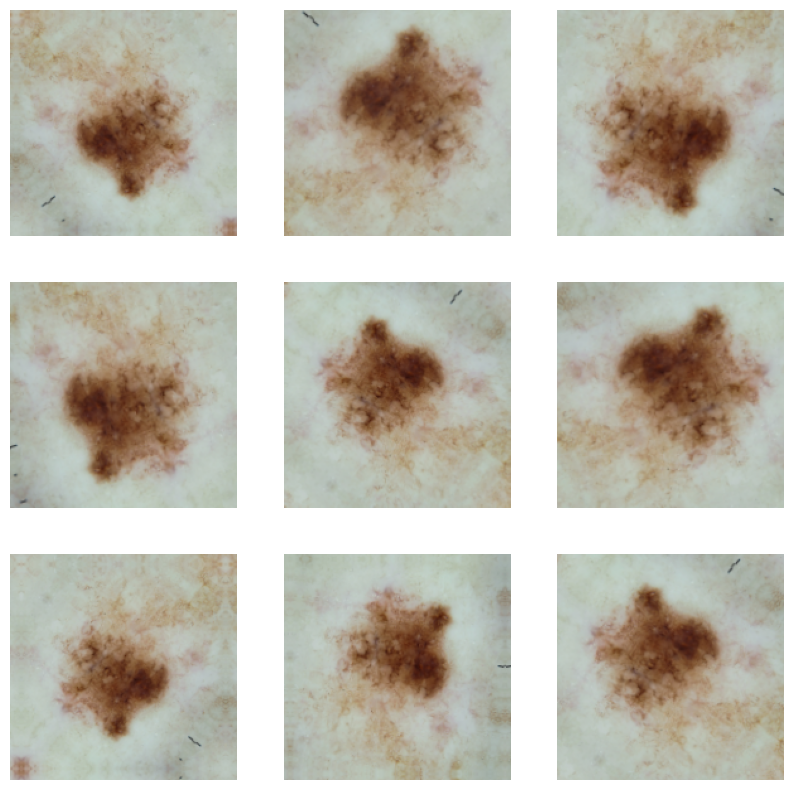

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Write your findings after the model fit, see if the earlier issue is resolved or not?

In [31]:
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation= 'relu'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(16,
                 kernel_size=(7, 7),
                 padding = 'Same',
                 activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,
                 kernel_size=(11, 11),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,
                 kernel_size=(3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [32]:
### Todo, choose an appropirate optimiser and loss function
compileModel(model=model)

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,16

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = [learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.1548 - loss: 2.0867 - val_accuracy: 0.2058 - val_loss: 2.0765 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.1934 - loss: 2.0367 - val_accuracy: 0.2058 - val_loss: 2.0219 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.2188 - loss: 1.9927 - val_accuracy: 0.2058 - val_loss: 2.0175 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.2277 - loss: 1.9972 - val_accuracy: 0.2081 - val_loss: 2.0421 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.1915 - loss: 1.9986 - val_accuracy: 0.2796 - val_loss: 1.8933 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.2961 - loss: 1.8533 - val_accuracy: 0.2841 - val_loss: 1.7999 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.3146 - loss: 1.

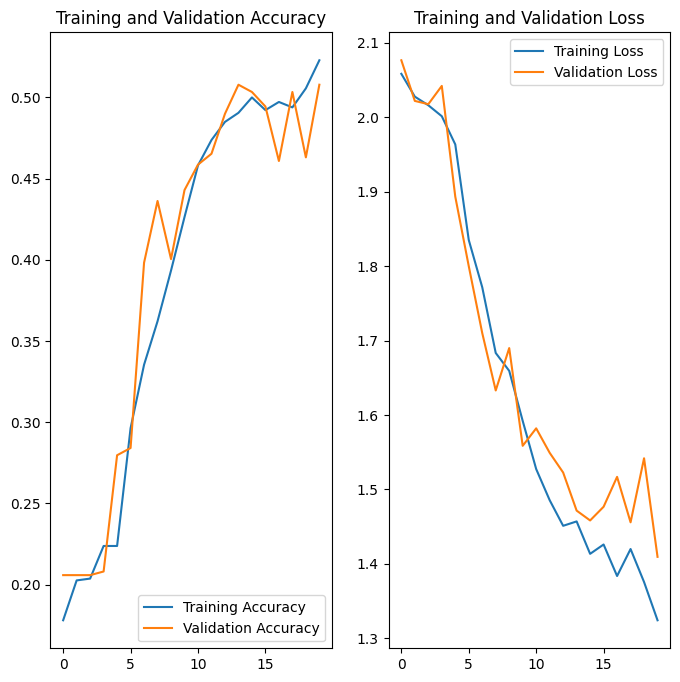

In [36]:
visualiseResult(model=model)

### Observation
- The Training accuracy and validation accuracy are almost same.
- The training accuracy is less than the validation accuracy. This could be a sign of underfitting
- This is a sign of good fit but the accuracy is still very low.
- The model requires more epochs to train with class imbalance handled.

# Class distribution:
Examine the current class distribution in the training dataset

- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?

In [37]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

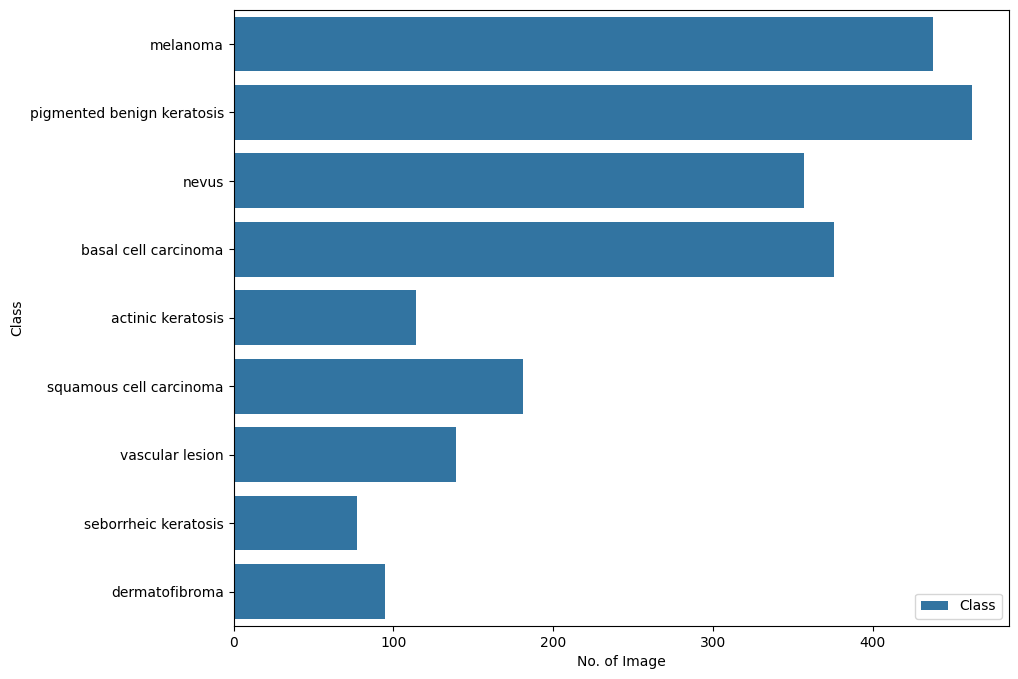

In [38]:
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Observations
**Which class has the least number of samples? <br/>**
**Result** `seborrheic keratosis` has 77 samples <br/>
**Which classes dominate the data in terms proportionate number of samples? <br/>**
**Result** `pigmented benign keratosis` has 462 samples <br/>

# Handling class imbalances
- Rectify class imbalances present in the training dataset with `Augmentor` library
- Augmentor Library - https://augmentor.readthedocs.io/en/master/ , https://github.com/mdbloice/Augmentor
- Use Augmentor package to add more images

In [39]:
# This is the code to install the augmentor package
# %conda install -c augmentor augmentor
!pip install Augmentor

DEPRECATION: kuma-utils 0.4.2 has a non-standard dependency specifier torch<3.0.0,>=2.1.1+cu118. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of kuma-utils or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: kuma-utils 0.4.2 has a non-standard dependency specifier torchaudio<3.0.0,>=2.1.1+cu118. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of kuma-utils or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: kuma-utils 0.4.2 has a non-standard dependency specifier torchvision<0.17.0,>=0.16.1+cu118. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of kuma-utils or contact 

In [40]:
import Augmentor

In [41]:
# path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
cancer_class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [42]:
for i in cancer_class_names:
  print(train_dir_path + i)
  p = Augmentor.Pipeline(train_dir_path + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)

Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2736050>: 100%|█|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2D2C690>: 100%|█|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2E25600D0>: 100%|█|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2E24051D0>: 100%|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E54B7BD0>: 100%|█|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E26341D0>: 100%|█|


Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E54E1150>: 100%|█|


Total 4500 images are present in the output directory

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [44]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new[:10]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000161.jpg_297ad713-d04c-4d7a-bd27-d904e14c9f23.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_2c178eed-2e4f-4503-9e43-20600e9ae5fe.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011039.jpg_5d439897-09d9-4972-8b85-4f9685842614.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000312.jpg_ccd98093-45d1-4a1d-9ccb-9b97da034e06.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010360.jpg_f825021b-e3db-4aef-9889-507401ed67ee.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010564.jpg_a9864f4e-227f-44b5-9cd5-28eac0fcf94c.jpg',
 'Skin cancer IS

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma']

In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [47]:
for i in cancer_class_names:
    directory = train_dir_path
    directory_out = train_dir_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


# Model Building & training on the rectified class imbalance data :
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~30 epochs
- Write your findings after the model fit, see if the issues are resolved or not?

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1)

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir_path,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir_path,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [50]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create Model using the Normalisation

In [51]:
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3))) 

model.add(layers.Conv2D(32,
                        kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,
                        kernel_size=(3,3),
                        activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Conv2D(128,
                        kernel_size=(3,3),
                        activation='relu'))

model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,
                        kernel_size=(11,11),
                        activation='relu'))

model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(256,
                       activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128,
                       activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64,
                       activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(cancer_class_names),
                       activation='softmax'))

/Users/mohit.dubey/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Choose an appropriate optimiser and loss function for model training

In [52]:
compileModel(model=model)

In [53]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 10, 10, 256)    │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,739,081 (21.89 MB)

 Trainable params: 5,738,953 (21.89 MB)

 Non-trainable params: 128 (512.00 B)

Train the model for ~30 epochs

In [54]:
epochs = 30

In [55]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = [learn_control]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 379ms/step - accuracy: 0.1686 - loss: 2.3881 - val_accuracy: 0.1403 - val_loss: 2.2485 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 381ms/step - accuracy: 0.2959 - loss: 1.8026 - val_accuracy: 0.1544 - val_loss: 2.6358 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.3898 - loss: 1.5897 - val_accuracy: 0.2739 - val_loss: 1.9869 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 384ms/step - accuracy: 0.4151 - loss: 1.5230 - val_accuracy: 0.2361 - val_loss: 2.8766 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.4339 - loss: 1.4591 - val_accuracy: 0.4477 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - accuracy: 0.4681 - loss: 1.3924 - val_accuracy: 0.4336 - val_loss: 1.5114 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 392ms/step - accuracy: 0.4

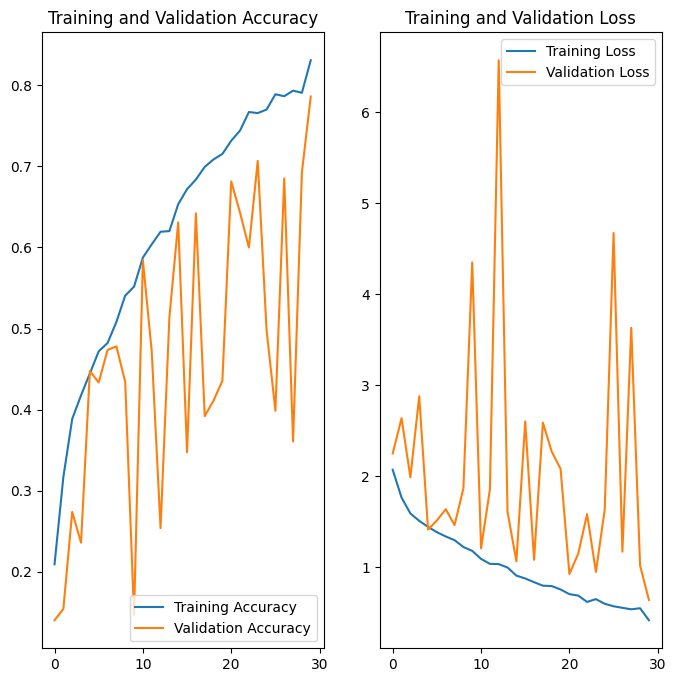

In [56]:
visualiseResult(model=model)

## Observations
### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
- Training and validation accuracy are very close to each other at the last epoch however they are fluctuating a lot
- Training accuracy at 30th epoch was 82% and validation accuracy was 78%
- Due to fluctuation, we can say that we see signs of overfitting here
- Model is able to classify 78% of images accurately

# Model prediction on test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[2.9523997e-03 5.8643574e-01 3.0098312e-02 5.8037676e-03 4.8015071e-03
  1.1090403e-01 1.1506649e-04 8.6397119e-03 2.5024951e-01]]
1
Actual Class: 		basal cell carcinoma
Predictive Class: 	basal cell carcinoma


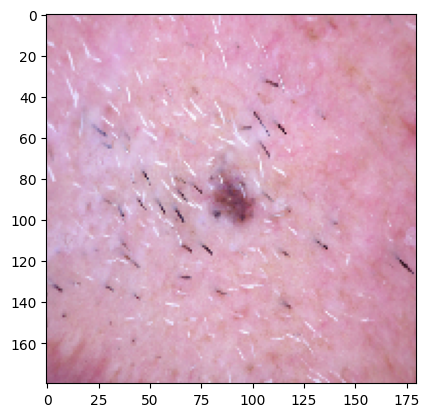

In [66]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_class = cancer_class_names[1]
test_image_path = os.path.join(data_dir_test, test_class, '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-1],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
print(pred)
pred = np.argmax(pred)
print(pred)
pred_class = cancer_class_names[pred]
print(f"Actual Class: \t\t{test_class}\nPredictive Class: \t{pred_class}")

The classified and original values are same. Hence Model performed well here